<a href="https://colab.research.google.com/github/AbhigyanSingh97/PUBG-data-visualization-and-prediction./blob/master/PubGPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:

train = pd.read_csv('/content/drive/My Drive/pubg-finish-placement-prediction/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('/content/drive/My Drive/pubg-finish-placement-prediction/test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)


Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [8]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


Checking the missing data

In [0]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [10]:
check_missing_data(train)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.24872e-09
Types,object,object,object,int8,int8,float32,int8,int8,int8,int8,int16,int8,int8,float32,int16,object,int8,int8,int16,int8,float32,int8,float32,int8,int8,float32,int16,int16,float32


In [11]:
check_missing_data(test)

False

# EDA and Data cleaning



## EDA

In [12]:
for i in ['Id','groupId','matchId']:
  print(f'unique[{i}] count',train[i].nunique())

unique[Id] count 4446966
unique[groupId] count 2026745
unique[matchId] count 47965


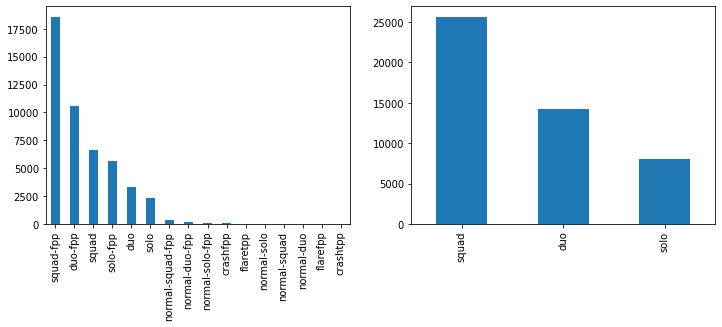

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

type_play = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(type_play)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

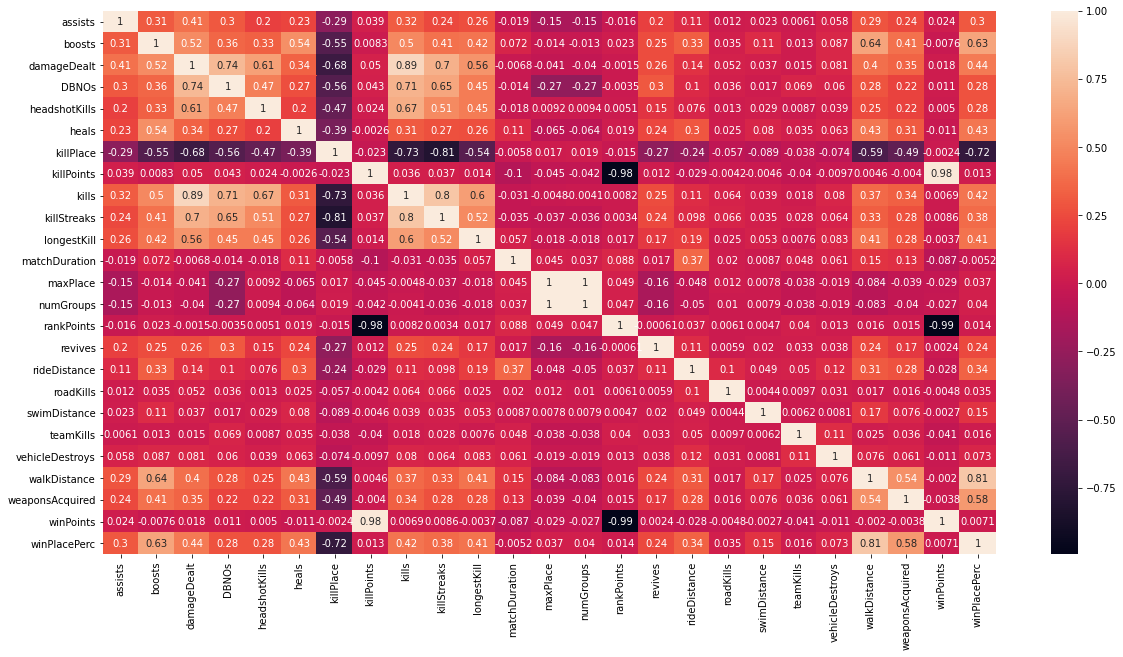

In [14]:
plt.figure(figsize = (20,10))
sns.heatmap(train.corr(),annot=True)

There's a high correlation between win points and kill points which makes sense that more the number of kills leads to the better chance of winning.Also,kills and damage dealt shows correlation as getting more kills will obviously leads to taking higher damage and walking distance and win place also shows correaltion as the people coming first are generally very active and kind off walks continously.

## Feature engineering

### distance analysis

In [0]:
DATA = train.copy() 

In [16]:
print(len(DATA[DATA['walkDistance']==0]))

99603


99603 people didnt walk a single meter.

In [17]:
print('{} % people died maybe because of being not active after the game started or were killed as soon as they touched or maybe in air.'.format(100*len(DATA[DATA['walkDistance']==0])/len(DATA)))

2.2397967513131425 % people died maybe because of being not active after the game started or were killed as soon as they touched or maybe in air.


In [18]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  print(i*100,'% people walked',DATA['walkDistance'].quantile(i))

10.0 % people walked 41.560001373291016
20.0 % people walked 110.0
30.0 % people walked 210.5
40.0 % people walked 376.70001220703125
50.0 % people walked 685.5999755859375
60.0 % people walked 1165.0
70.0 % people walked 1696.0
80.0 % people walked 2267.0
90.0 % people walked 2920.0
100 % people walked 25780.0


It can be seen 90% of the people travel 2920 m however the huge jump on the 100% shows the presence of outlier or some hacker.

In [19]:
for i in [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.99,0.99,1]:
  print(i*100,'% people got walks',DATA['walkDistance'].quantile(i))

90.0 % people got walks 2920.0
91.0 % people got walks 2999.0
92.0 % people got walks 3084.0
93.0 % people got walks 3177.0
94.0 % people got walks 3279.0
95.0 % people got walks 3396.0
96.0 % people got walks 3536.0
97.0 % people got walks 3714.0
99.0 % people got walks 4396.0
99.0 % people got walks 4396.0
100 % people got walks 25780.0


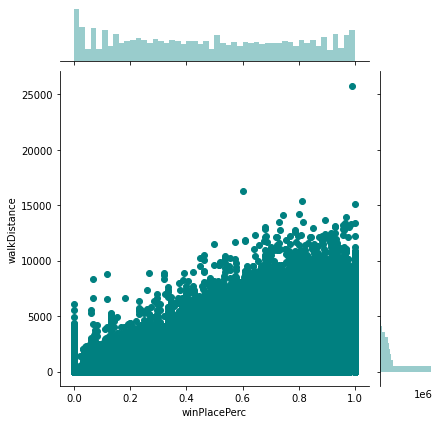

In [20]:
sns.jointplot(DATA['winPlacePerc'],DATA['walkDistance'],color = 'teal')
plt.show()

This confirms that people having more walk distance has more chances of winning

### kill analysis

In [0]:
data = train.copy()

In [22]:
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875


In [23]:
data['kills'].mean()

0.9247833241810259

In [24]:
print('minimum kills',data['kills'].min())
print('maximum kills',data['kills'].max())

minimum kills 0
maximum kills 72


In [25]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  print(i*100, 'percent of people gets {} kills.'.format(data['kills'].quantile(i)))

10.0 percent of people gets 0.0 kills.
20.0 percent of people gets 0.0 kills.
30.0 percent of people gets 0.0 kills.
40.0 percent of people gets 0.0 kills.
50.0 percent of people gets 0.0 kills.
60.0 percent of people gets 1.0 kills.
70.0 percent of people gets 1.0 kills.
80.0 percent of people gets 2.0 kills.
90.0 percent of people gets 3.0 kills.
100 percent of people gets 72.0 kills.


50% of the individual are not even getting a single kill,Clearly it shows there are a lot of outliers present in the data after 90% mark, let's see what is the average kills for population between 90 - 100.


In [26]:
for i in [0.9,0.91,0.92,0.93,0.94,0.95,0.6,0.97,0.98,0.99,1]:
  print(i,'precent of people gets {} kills.'.format(data['kills'].quantile(i)))

0.9 precent of people gets 3.0 kills.
0.91 precent of people gets 3.0 kills.
0.92 precent of people gets 3.0 kills.
0.93 precent of people gets 3.0 kills.
0.94 precent of people gets 4.0 kills.
0.95 precent of people gets 4.0 kills.
0.6 precent of people gets 1.0 kills.
0.97 precent of people gets 5.0 kills.
0.98 precent of people gets 6.0 kills.
0.99 precent of people gets 7.0 kills.
1 precent of people gets 72.0 kills.


It's tough to get 72 kills in a SINGLE MATCH,it is nearly impossible.
let's find out whether the data of hacker is present in the data.

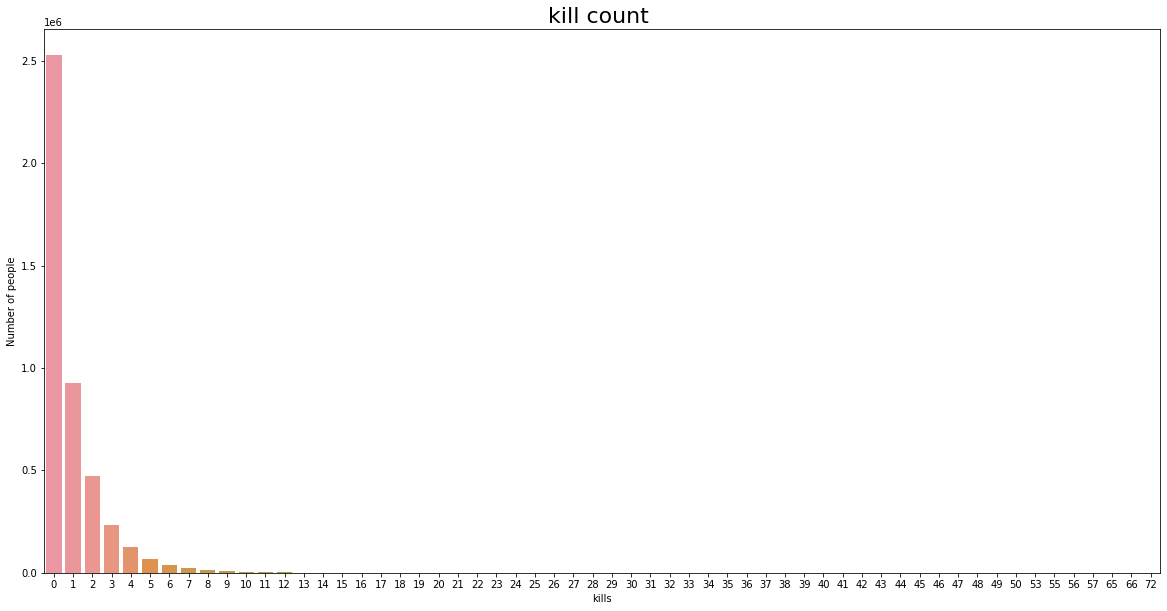

In [27]:
plt.figure(figsize = (20,10))
sns.countplot(data['kills'].sort_values())
plt.xlabel('kills')
plt.ylabel('Number of people')
plt.title('kill count ',fontsize = 22)
plt.show()

Most of the people are only getting 0 kills,Barely people are crossing kill count 2,so people in the range 15-72 either have to be talented or must be using some kind of hacks.

In [28]:
data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [29]:
d_kill0 = data[data['kills']==0]
print ('People winning without a single kill',len(d_kill0[d_kill0['winPlacePerc']==1]),'which is {} %.'.format(100*(len(d_kill0[d_kill0['winPlacePerc']==1])/len(data[data['winPlacePerc']==1]))))

People winning without a single kill 16666 which is 13.063892829987536 %.


In [0]:
data['kill_cate'] = pd.cut(data['kills'],[-1,0,2,4,6,8,10,80],labels=['kill 0','kill 1-2','kill 3-4','kill 5-6','kill 7-8','kill 9-10','kill 10+'])


In [31]:
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,kill_cate
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,1241,0,0,0.000000,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.800003,1,1466,0.4444,kill 0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,0,0,0,0.000000,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.000000,5,0,0.6400,kill 0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,0,0,0,0.000000,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.800003,2,0,0.7755,kill 0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,0,0,0,0.000000,1436,squad,31,30,1408,0,0.0000,0,0.00,0,0,202.699997,3,0,0.1667,kill 0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,0,1,1,58.529999,1424,solo,97,95,1560,0,0.0000,0,0.00,0,0,49.750000,2,0,0.1875,kill 1-2


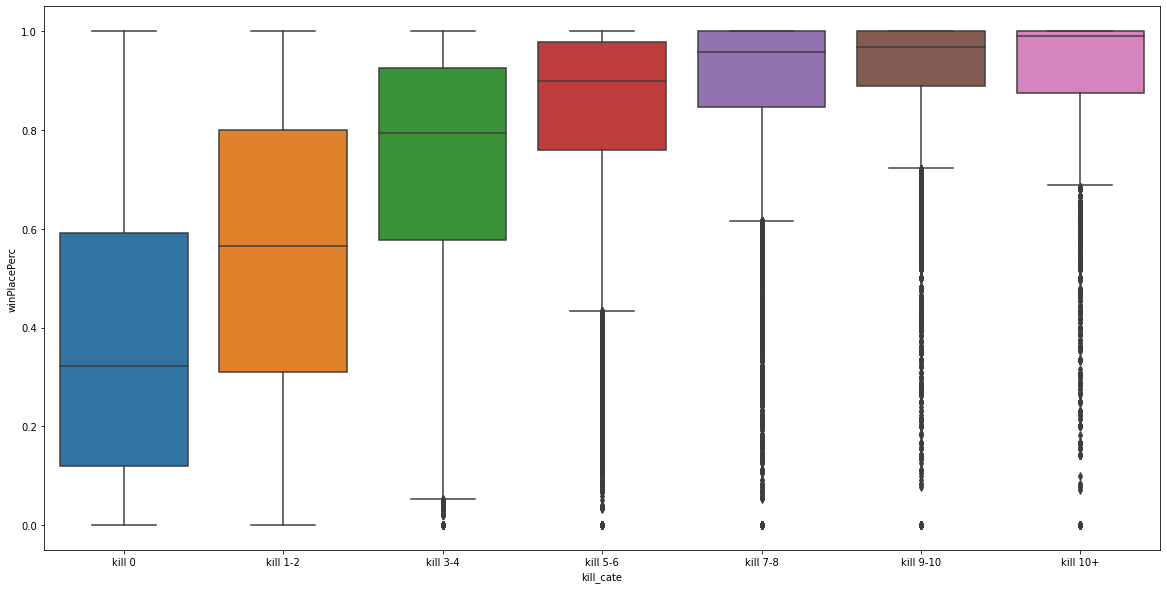

In [32]:
plt.figure(figsize=(20,10))
sns.boxplot(data['kill_cate'],data['winPlacePerc'])
plt.show()

This clearly shows that high kill numbers leads to a better chance of coming in first place.But there is also a huge amount of outliers as kill numbers does not always lead to winning a match,there can be a player with 10 kills loosing to a player with 0 kills.

### Analysing Ride distance

In [0]:
dataride = train.copy()

In [34]:
dataride['rideDistance'].mean()

606.0923461914062

Turns out that average distance travelled is 606 meter for the entire data.

In [35]:
print(dataride['rideDistance'].max())
print(dataride['rideDistance'].min())

40710.0
0.0


In [36]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  print(i*100,"% of people travelled {} meters.".format(dataride['rideDistance'].quantile(i)))

10.0 % of people travelled 0.0 meters.
20.0 % of people travelled 0.0 meters.
30.0 % of people travelled 0.0 meters.
40.0 % of people travelled 0.0 meters.
50.0 % of people travelled 0.0 meters.
60.0 % of people travelled 0.0 meters.
70.0 % of people travelled 0.0 meters.
80.0 % of people travelled 610.5999755859375 meters.
90.0 % of people travelled 2391.0 meters.
100 % of people travelled 40710.0 meters.


Turns out that 70% of the people don't even use the vehicle in the game,they believe in walking.
also a huge jump is seen between 90-100% of the population and indicates the presence of hacker or maybe an outlier.

In [37]:
for i in [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]:
  print(i*100,"% people travelled {} meters.".format(dataride['rideDistance'].quantile(i)))

90.0 % people travelled 2391.0 meters.
91.0 % people travelled 2663.0 meters.
92.0 % people travelled 2960.0 meters.
93.0 % people travelled 3285.0 meters.
94.0 % people travelled 3643.0 meters.
95.0 % people travelled 4048.0 meters.
96.0 % people travelled 4512.0 meters.
97.0 % people travelled 5079.0 meters.
98.0 % people travelled 5815.0 meters.
99.0 % people travelled 6966.0 meters.
100 % people travelled 40710.0 meters.


99% of the population travel about 6966 meters.

let's see can this help in win place.

In [0]:
dataride0 = dataride[dataride['rideDistance']==0]

In [39]:
print(len(dataride0['winPlacePerc']==1))

3309429


33 lakh people won the game without even riding a single meter.

<Figure size 1440x720 with 0 Axes>

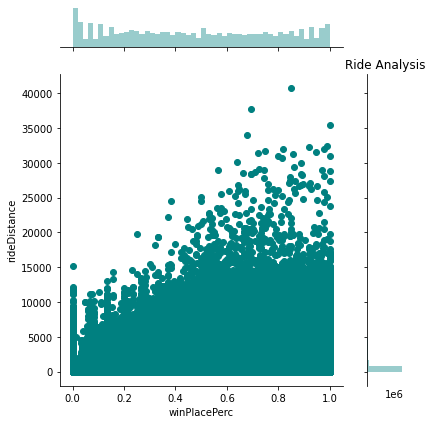

In [40]:
plt.figure(figsize=(20,10))
sns.jointplot(dataride['winPlacePerc'],dataride['rideDistance'],color='teal')
plt.title('Ride Analysis')
plt.tight_layout()

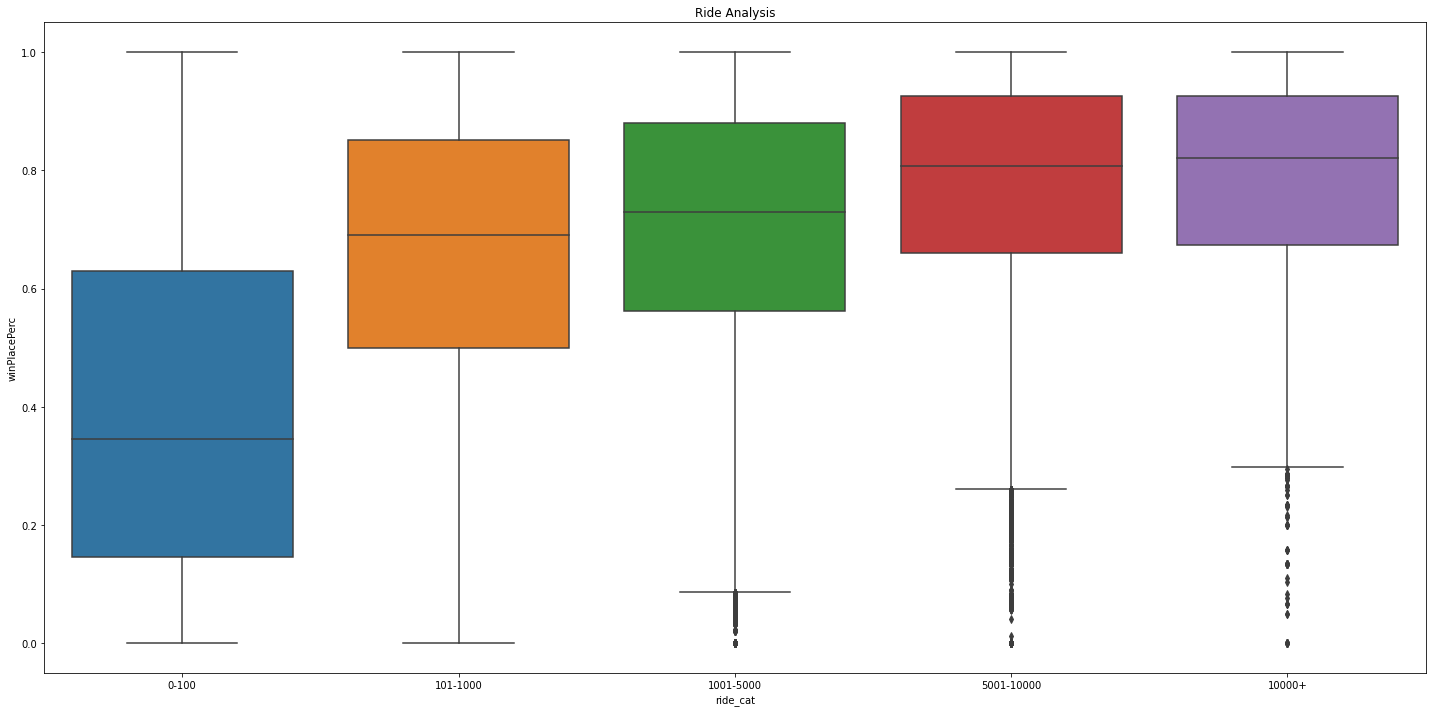

In [41]:
dataride1 = train.copy()
dataride1['ride_cat'] = pd.cut(dataride['rideDistance'],(-1,100,1000,5000,10000,50000),labels=['0-100','101-1000','1001-5000','5001-10000','10000+'])

plt.figure(figsize=(20,10))
sns.boxplot(dataride1['ride_cat'],dataride1['winPlacePerc'])
plt.title('Ride Analysis')
plt.tight_layout()

This shows that people travelling more than 5000 m have almost 80% chance of winning the match.

### Heals analysis

In [0]:
Healdata = train.copy()

In [43]:
Healdata['heals'].mean()

1.370147196987789

average of one heal is used by all the players in a single match.

In [44]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  print(i*100,"% of players uses {} heals per match.".format(Healdata['heals'].quantile(i)))

10.0 % of players uses 0.0 heals per match.
20.0 % of players uses 0.0 heals per match.
30.0 % of players uses 0.0 heals per match.
40.0 % of players uses 0.0 heals per match.
50.0 % of players uses 0.0 heals per match.
60.0 % of players uses 1.0 heals per match.
70.0 % of players uses 1.0 heals per match.
80.0 % of players uses 2.0 heals per match.
90.0 % of players uses 5.0 heals per match.
100 % of players uses 80.0 heals per match.


turns out that 50% of the data don't use heal at all,which is makes sense,as we saw that these 50% of the population don't eve walk a single meter in the game.However a huge jump is seen in the 90-100 range.

In [45]:
for i in [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]:
  print(i*100,"% players use {} heals.".format(Healdata['heals'].quantile(i)))

90.0 % players use 5.0 heals.
91.0 % players use 5.0 heals.
92.0 % players use 5.0 heals.
93.0 % players use 6.0 heals.
94.0 % players use 6.0 heals.
95.0 % players use 7.0 heals.
96.0 % players use 7.0 heals.
97.0 % players use 8.0 heals.
98.0 % players use 10.0 heals.
99.0 % players use 12.0 heals.
100 % players use 80.0 heals.


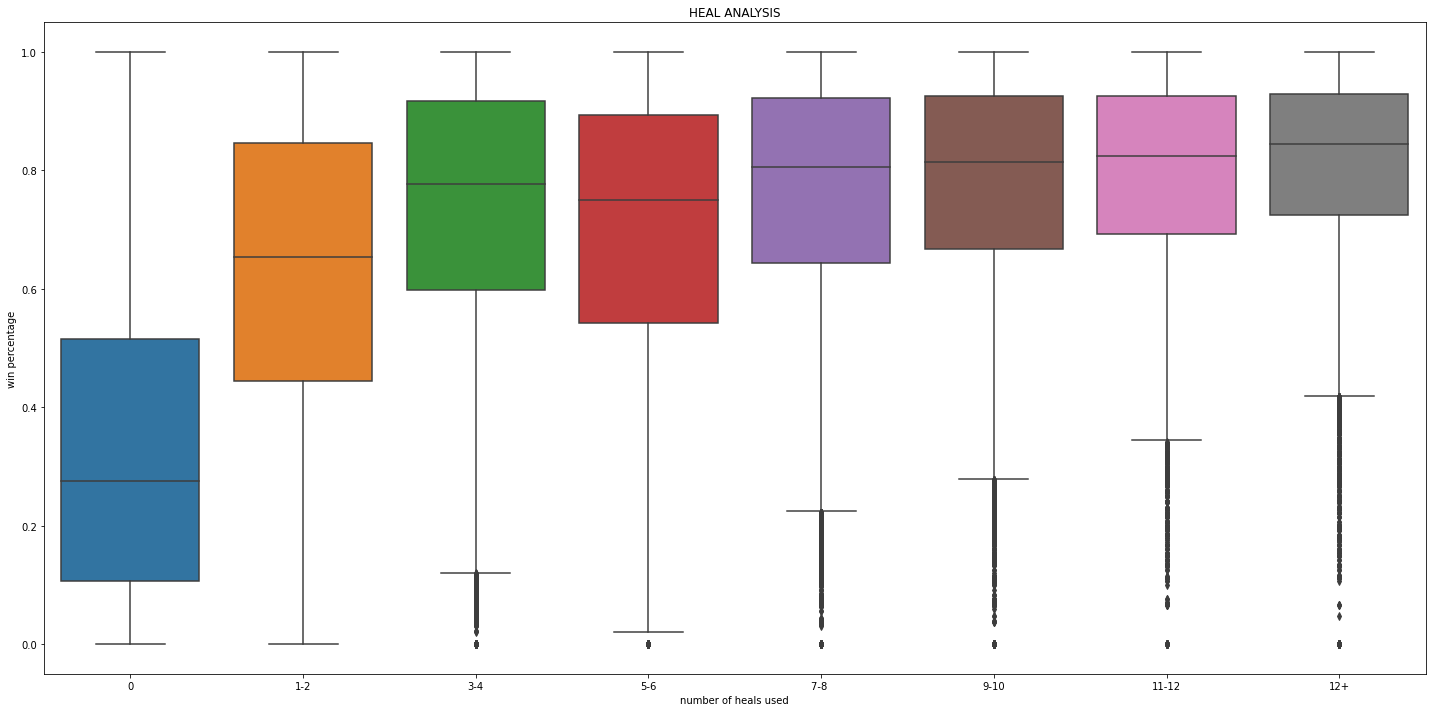

In [46]:
healdata = Healdata.copy()
healdata['heal_cat'] = pd.cut(Healdata['heals'],(-1,0,2,4,6,8,10,12,90),labels=['0','1-2','3-4','5-6','7-8 ','9-10','11-12','12+'])

plt.figure(figsize=(20,10))
sns.boxplot(healdata['heal_cat'],healdata['winPlacePerc'])
plt.title("HEAL ANALYSIS")
plt.xlabel("number of heals used")
plt.ylabel("win percentage")
plt.tight_layout()

people using more than 3 heals per game show around 80% chance of winning,However outliers are higher as it does not guarantee the win.

### Analysing weapon acquired

In [0]:
weapdata = train.copy()

In [48]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.96,0.99,1]:
  print(i*100,"% players use {} heals.".format(weapdata['weaponsAcquired'].quantile(i)))

10.0 % players use 1.0 heals.
20.0 % players use 2.0 heals.
30.0 % players use 2.0 heals.
40.0 % players use 3.0 heals.
50.0 % players use 3.0 heals.
60.0 % players use 4.0 heals.
70.0 % players use 5.0 heals.
80.0 % players use 5.0 heals.
90.0 % players use 7.0 heals.
93.0 % players use 7.0 heals.
96.0 % players use 8.0 heals.
99.0 % players use 10.0 heals.
100 % players use 236.0 heals.


let's first see people with no weapon winning a match.

In [49]:
weapdata1 = weapdata[weapdata['weaponsAcquired']==0]
print(len(weapdata1['weaponsAcquired']))

226578


About 2 lakh people with no weapon played the gun.

In [50]:
print(len(weapdata1[weapdata1['winPlacePerc']==1])," people came first with no weapon,which is about",100*(len(weapdata1[weapdata1['winPlacePerc']==1])/len(weapdata[weapdata['winPlacePerc']==1])),"%")

201  people came first with no weapon,which is about 0.15755684980364185 %


Maybe these people were in a squad or maybe duo or maybe in solo.This makes sense because winning without weapon is hard.

In [0]:
weapdata2 = weapdata1[weapdata1['winPlacePerc']==1]

In [52]:
weapdata2.groupby('matchType').nunique()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
matchType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
duo,19,17,17,3,5,12,3,2,4,16,6,6,4,10,16,1,8,9,6,2,10,5,1,2,1,19,1,6,1
solo,17,15,15,1,2,5,1,1,2,4,1,1,1,1,2,1,4,1,1,1,2,1,3,1,1,3,1,1,1
squad,165,154,154,3,5,28,4,1,3,29,54,5,3,8,135,1,12,13,83,2,34,3,11,2,2,149,1,46,1


Turns out most of them belonged to squad about 165 of them,17 were in solo and rest 19 in a duo match.

### Analysing team kills

In [0]:
teamdata = train.copy()

In [0]:
teamdata = teamdata.groupby('matchType')
squad = teamdata.get_group('squad')
duo = teamdata.get_group('duo')
solo = teamdata.get_group('solo')

In [55]:
print("Maximum squad kills is",squad['kills'].max())
print("Maximum duo kills is",duo['kills'].max())
print("Maxximum solo kill is",solo['kills'].max())

Maximum squad kills is 72
Maximum duo kills is 57
Maxximum solo kill is 66


Let's analyse the squad kills

In [56]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.96,0.99,1]:
  print(i*100,"% of squad gets {} kills.".format(squad['kills'].quantile(i)))

10.0 % of squad gets 0.0 kills.
20.0 % of squad gets 0.0 kills.
30.0 % of squad gets 0.0 kills.
40.0 % of squad gets 0.0 kills.
50.0 % of squad gets 0.0 kills.
60.0 % of squad gets 1.0 kills.
70.0 % of squad gets 1.0 kills.
80.0 % of squad gets 2.0 kills.
90.0 % of squad gets 3.0 kills.
93.0 % of squad gets 3.0 kills.
96.0 % of squad gets 4.0 kills.
99.0 % of squad gets 7.0 kills.
100 % of squad gets 72.0 kills.


In [57]:
squad0 = squad[squad['kills']==0]

print(len(squad0[squad0['winPlacePerc']==1])," squads won without a single kill,which is {}% .".format(100*(len(squad0[squad0['winPlacePerc']==1])/len(squad0))))

13980  squads won without a single kill,which is 1.020027711482462% .


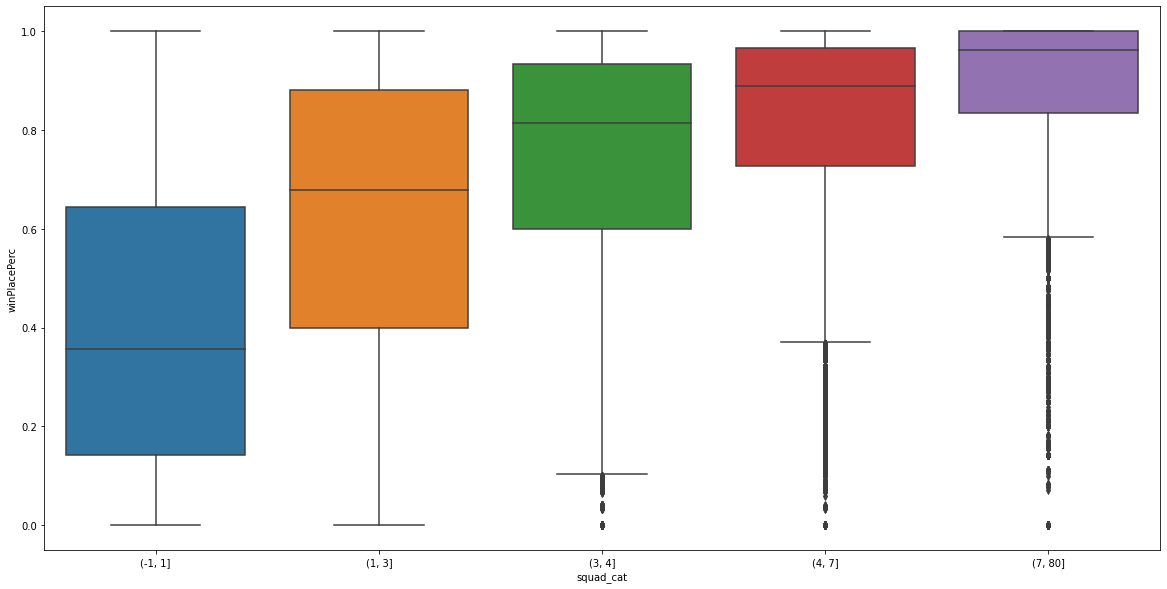

In [58]:
squad['squad_cat'] = pd.cut(squad['kills'],[-1,1,3,4,7,80])
plt.figure(figsize=(20,10))
sns.boxplot(squad['squad_cat'],squad['winPlacePerc'])

squad with more than 4 kills had greater chances of winning

Duo analysis

In [59]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.96,0.99,1]:
  print(i*100,"% of duo gets {} kills.".format(duo['kills'].quantile(i)))

10.0 % of duo gets 0.0 kills.
20.0 % of duo gets 0.0 kills.
30.0 % of duo gets 0.0 kills.
40.0 % of duo gets 0.0 kills.
50.0 % of duo gets 0.0 kills.
60.0 % of duo gets 1.0 kills.
70.0 % of duo gets 1.0 kills.
80.0 % of duo gets 2.0 kills.
90.0 % of duo gets 3.0 kills.
93.0 % of duo gets 3.0 kills.
96.0 % of duo gets 4.0 kills.
99.0 % of duo gets 7.0 kills.
100 % of duo gets 57.0 kills.


In [60]:
duo0 = duo[duo['kills']==0]
print(len(duo0[duo0['winPlacePerc']==1])," duos won without a single kill,which is {}%.".format(100*(len(duo0[duo0['winPlacePerc']==1])/len(duo0))))


1743  duos won without a single kill,which is 0.2292600542963571%.


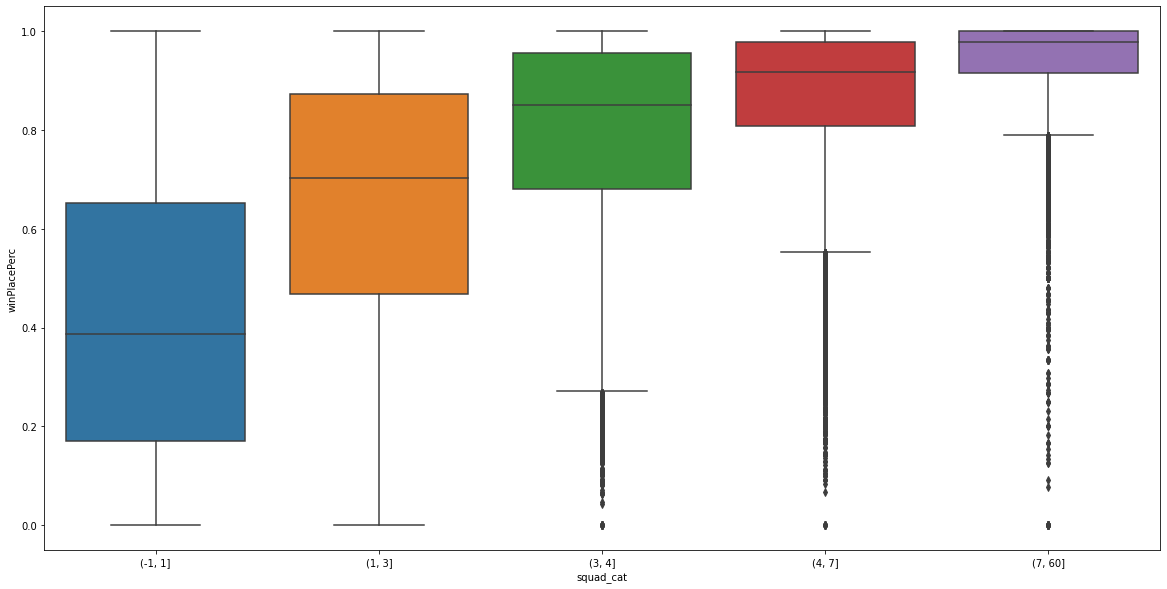

In [61]:
duo['squad_cat'] = pd.cut(duo['kills'],[-1,1,3,4,7,60])
plt.figure(figsize=(20,10))
sns.boxplot(duo['squad_cat'],duo['winPlacePerc'])

duo with kill more than 4 had better probability of winning

Solo analysis

In [62]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.96,0.99,1]:
  print(i*100,"% of solo gets {} kills.".format(solo['kills'].quantile(i)))

10.0 % of solo gets 0.0 kills.
20.0 % of solo gets 0.0 kills.
30.0 % of solo gets 0.0 kills.
40.0 % of solo gets 0.0 kills.
50.0 % of solo gets 0.0 kills.
60.0 % of solo gets 1.0 kills.
70.0 % of solo gets 1.0 kills.
80.0 % of solo gets 2.0 kills.
90.0 % of solo gets 3.0 kills.
93.0 % of solo gets 3.0 kills.
96.0 % of solo gets 4.0 kills.
99.0 % of solo gets 7.0 kills.
100 % of solo gets 66.0 kills.


In [63]:
solo0 = solo[solo['kills']==0]
print(len(solo0[solo0['winPlacePerc']==1])," solo players won without a single kill,which is {}%.".format(100*(len(solo0[solo0['winPlacePerc']==1])/len(solo0))))

943  solo players won without a single kill,which is 0.23640069290722715%.


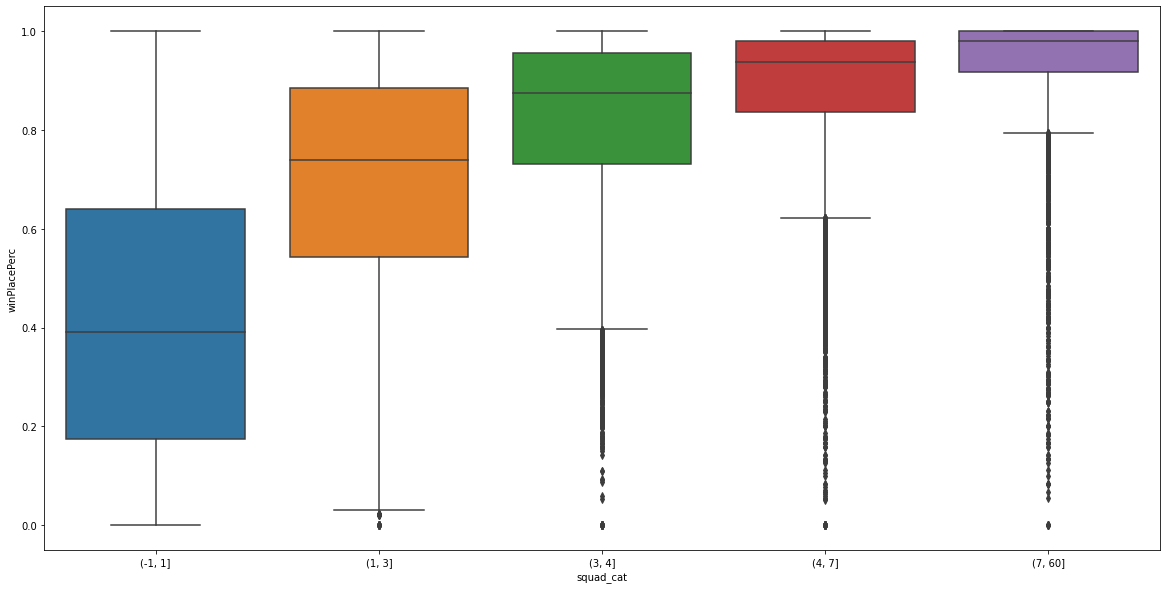

In [64]:
solo['squad_cat'] = pd.cut(solo['kills'],[-1,1,3,4,7,60])
plt.figure(figsize=(20,10))
sns.boxplot(solo['squad_cat'],solo['winPlacePerc'])

### Removing the outliers or hackers.

In [65]:
train.shape

(4446966, 29)

In [0]:
train.drop(train[train['winPlacePerc'].isnull()].index,inplace=True)

In [67]:
train.shape

(4446965, 29)

In [68]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [0]:
data_new = train.copy()


In [70]:
data_new[(data_new['kills']>0) & (data_new['walkDistance']==0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,0,6,3,23.540001,593,squad,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,0,3,1,6.523000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,0,20,6,37.080002,898,solo,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,1000,1,1,21.540001,799,squad,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,0,1,1,55.430000,1794,squad,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4440232,1f3a6d69d22c7e,60b2849191c539,ff9cd80c0d8fb7,0,0,4.316000,0,0,0,61,1000,1,1,41.250000,799,squad,10,10,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.8889
4440898,a089cb33a75968,eda174acfb503b,4c6b1a0e4cb346,0,0,90.830002,0,0,4,42,0,1,1,48.230000,1794,squad,2,2,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.0000
4440927,0634c650048997,5ccccee03a7f17,fc0bbecba8db99,2,2,909.099976,7,2,16,26,1000,6,2,154.800003,1796,squad,11,11,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.6000
4441511,f5d385cadfab7e,a068f79011113c,fc0bbecba8db99,6,2,696.400024,9,2,0,18,1000,9,2,89.519997,1796,squad,11,11,-1,10,0.0,0,0.0,1,0,0.0,16,1500,0.9000


These players for sure are cheating as no one can get a single kill from not walking or moving at all,So let's remove them.

In [0]:
data_new.drop(data_new[(data_new['kills']>0) & (data_new['walkDistance']==0)].index,inplace = True)

Let's also remove people who have walked a great distance without a single kill.

In [72]:
data_new[(data_new['walkDistance']>7000) & (data_new['kills']==0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4942,55bdaf3722ba29,c42f9d608bacf9,b9180fc0b665c5,0,2,0.000000,0,0,6,54,0,0,0,0.0,1884,solo,95,93,1524,0,0.028300,0,67.349998,0,0,9325.0,3,0,0.6915
5199,e09430aff80b73,a7670f0aeb2259,45b0a0cf5e014d,0,0,21.540001,0,0,1,63,1175,0,0,0.0,1874,squad,30,30,0,0,0.034800,0,470.799988,0,0,7155.0,3,1544,0.4828
8760,5b342502229901,901cbeb065a18a,d0fa7e63daa3ba,0,4,49.299999,0,0,0,51,1106,0,0,0.0,1448,squad,28,27,-1,0,0.004000,0,30.190001,0,0,7352.0,4,1519,0.8889
12579,2f7629a6d8dd69,3129d0cbd055b2,9858c75dbbb4df,0,2,52.259998,0,0,5,40,0,0,0,0.0,1908,solo,99,90,2015,0,1912.000000,0,17.190001,0,0,7313.0,2,0,0.9694
13699,f010bf756b3ad4,105d235ea915cb,4411fd7991f968,0,1,0.000000,0,0,0,43,0,0,0,0.0,1865,duo,50,48,1512,0,1701.000000,0,63.160000,0,0,8767.0,4,0,0.7959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4424347,9612c1eba5b394,8fb1f633a0725f,2cdae31ee18601,0,2,0.000000,0,0,6,49,0,0,0,0.0,1896,duo,48,46,1500,0,0.045000,0,35.790001,0,0,8312.0,8,0,0.6170
4426318,e5e779fe07b70d,e44f24df4a8f14,c1c64ed04aea47,0,0,29.639999,0,0,0,60,0,0,0,0.0,1869,solo,96,94,1499,0,0.027000,0,43.880001,0,0,8111.0,3,0,0.6105
4430073,6cde307e4081a7,57c88e15f79af3,5b66793e5c260f,0,1,0.000000,0,0,1,58,1146,0,0,0.0,1821,squad,27,27,-1,0,0.017500,0,12.750000,0,0,9487.0,4,1455,0.6154
4439434,82387aec17209e,f710cc8626b879,2ec09aa461eec2,0,0,0.000000,1,0,3,53,0,0,0,0.0,1861,duo,49,46,1491,1,229.899994,0,169.399994,0,0,8227.0,2,0,0.6042


In [0]:
data_new.drop(data_new[(data_new['walkDistance']>7000) & (data_new['kills']==0)].index,inplace=True)

Let's see people having kills from more than 900m.

In [74]:
data_new[(data_new['longestKill']>900) & (data_new['kills']>0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
49933,8d84a760b76634,dcbeb664940a34,ecf0c4f12fbd6a,0,4,1550.000000,14,10,2,1,0,16,4,953.599976,1835,squad,29,28,1573,4,5171.0,0,0.000,0,0,3390.000000,4,0,0.7143
144856,0d65331cbe09bf,f50d852ff41035,6575f2a4ef9fd4,5,0,869.599976,0,3,0,8,0,10,2,964.500000,595,squad,5,5,1500,0,0.0,0,0.000,0,0,241.199997,16,0,0.7500
156541,dd0a5d30e785c0,4cb8d3787b8150,a211eaf999b492,2,0,1119.000000,0,2,1,11,1000,11,2,981.400024,898,solo,21,12,-1,0,0.0,0,0.000,0,0,27.350000,31,1500,0.5000
180680,14eda1bf0c65f8,ad03385288412a,6b9acd66007d2a,2,5,121.599998,0,0,1,25,0,1,1,996.099976,1955,duo,48,47,1455,2,0.0,0,0.000,0,0,3500.000000,7,0,0.8936
195021,f141f7e776138b,a0fa42bf37e9f0,0b4c9543bc9199,1,4,784.200012,5,4,5,4,1195,4,2,999.900024,2190,duo,34,31,-1,0,6247.0,0,0.000,0,0,3678.000000,5,1523,0.8485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041660,9ae1d3fed21268,ab1ff79230e878,13521e5c0d1dd8,0,8,1683.000000,8,12,2,1,0,14,2,980.099976,2179,duo,48,47,1521,0,3077.0,0,4.742,0,0,3461.000000,5,0,0.9362
4170265,1243129ec692ab,c4bf6a28c1e0bf,b82d57cc24f3e1,2,3,1896.000000,15,8,2,1,0,10,2,940.599976,1809,squad,25,24,1610,0,4201.0,0,0.000,0,0,2433.000000,5,0,0.9583
4323434,1cfc42b9d2b730,4efd5f11ec2084,f843b77365f44d,0,4,1892.000000,0,16,3,1,988,18,3,940.099976,1778,solo,95,94,-1,0,2137.0,0,0.000,0,0,3521.000000,3,1478,1.0000
4332473,d8857d3d7e31b6,085de7a36897e6,42f997c16d8a0e,5,0,1685.000000,11,3,18,8,1000,16,2,1040.000000,1793,duo,12,11,-1,1,0.0,0,0.000,0,0,523.299988,35,1500,0.9091


Almost 140 people with kills above 900 m,this can happen when using a sniper but atmost 4-6kills on average can be said that people having those kill are pro players so we'll remove player with more than 5 kills


In [0]:
data_new.drop(data_new[(data_new['longestKill']>900) & (data_new['kills']>5)].index,inplace=True)

Let's see people who used less than 3 heals and have huge amount of kills.

In [76]:
data_new[(data_new['heals']==0) & (data_new['kills']>15)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
19531,ef706f0f248dbf,f27e63bfc6746c,7d2fd7f5d4f8b2,9,0,2856.0,32,3,0,1,0,24,4,84.230003,1195,squad,6,6,1500,0,0.0,0,0.0,0,0,1136.000000,20,0,0.8000
22389,5983e465259215,073b5cfb8f2b06,d4862967bcf3f0,2,0,1324.0,0,2,0,4,1000,18,3,114.000000,936,squad,5,5,-1,0,0.0,0,0.0,0,0,35.209999,28,1500,0.5000
57490,367599b150318a,0370e2f3be345b,5f2f9fcb9705af,6,0,2459.0,0,3,0,2,0,23,3,100.000000,910,duo,7,6,1500,0,0.0,0,0.0,0,0,208.500000,12,0,0.8333
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,1000,35,3,105.800003,1798,duo,8,7,-1,0,0.0,0,0.0,0,0,48.820000,48,1500,0.8571
124577,17f647ce2b0542,8014652d9e9100,d89631afea0b96,3,3,1448.0,0,6,0,2,1000,20,3,109.500000,897,duo,16,13,-1,0,0.0,0,0.0,0,0,29.940001,31,1500,0.9333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4355766,9d5398ebba538c,60b2849191c539,ff9cd80c0d8fb7,1,1,1872.0,0,6,0,2,1000,20,6,212.899994,799,squad,10,10,-1,0,1055.0,0,0.0,0,0,1725.000000,8,1500,0.8889
4390901,310cdfbe701f03,02b0ccfda16b93,f755207f23cf88,2,4,2645.0,16,8,0,1,0,24,5,436.700012,1319,squad,27,27,1526,0,0.0,0,0.0,0,0,3180.000000,7,0,1.0000
4391195,8014c707c41c9c,055cf2054902b4,5b543c89ad70f7,6,0,1702.0,0,5,0,3,1000,19,3,72.900002,949,solo,10,8,0,0,0.0,0,0.0,0,0,149.399994,33,1500,0.8889
4422538,502e7c4b858f43,164cf32990ef6f,10f129a6c2be8d,3,1,1389.0,0,8,0,1,1000,16,3,140.300003,890,duo,6,5,-1,0,0.0,0,0.0,0,0,699.099976,16,1500,1.0000


Is it even possible to get more than 15 kills without using a single heal.This sure means some kind of hacker.So,let's remove these.

In [0]:
data_new.drop(data_new[(data_new['heals']==0) & (data_new['kills']>15)].index,inplace = True)

Let's also remove people using high number of heals with no kills.

In [78]:
data_new[(data_new['heals']>15) & (data_new['kills']==0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1052,1a06d47b65a4ea,1291de583fe414,e612c476dc4e4f,0,6,8.345000,0,0,17,47,1446,0,0,0.0,1835,squad,28,28,-1,0,8992.0,0,122.500000,0,0,2522.0,4,1529,0.8889
2296,3ff77e912b95a4,3da0a0610b6578,a9586bc2797969,0,5,0.000000,0,0,29,45,0,0,0,0.0,1882,solo,96,94,1508,0,759.0,0,0.000000,0,1,2042.0,6,0,0.9263
2418,672833ad9e9c3d,41d210e8e55296,462e08ffa03009,0,3,90.739998,0,0,17,40,1126,0,0,0.0,1871,duo,50,47,-1,1,6144.0,0,0.000000,0,0,2239.0,6,1501,0.8980
3157,44642ba72f64ae,3c9c2daa2c3e01,34931a75615feb,0,6,0.000000,0,0,17,42,0,0,0,0.0,1425,solo,86,84,1757,0,1232.0,0,0.000000,0,0,2490.0,6,0,0.9176
5851,dcb9b97e32f6b3,c3c88b43a0e704,f74c834fdcd65a,1,6,139.899994,1,0,22,37,1319,0,0,0.0,1814,squad,29,27,-1,0,2608.0,0,0.000000,0,0,5210.0,3,1510,0.8571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4442986,0817c48ea8f67a,1e402e2734ad02,0c33a4fca13dcc,0,6,0.000000,0,0,16,58,0,0,0,0.0,1910,duo,49,47,1522,0,7688.0,0,0.000000,0,0,1851.0,6,0,0.6250
4444213,58ac9ad4c6a1bc,c3cb17248c1629,749348acb18517,1,3,70.629997,0,0,16,47,1334,0,0,0.0,1910,squad,27,27,-1,0,9786.0,0,0.000000,0,0,2438.0,7,1518,0.7692
4445664,bf7fec8907b9f6,1fe1e689498e91,1ec9b778d051c3,0,9,0.000000,0,0,16,42,0,0,0,0.0,2013,solo,93,90,1522,0,0.0,0,9.594000,0,0,3952.0,4,0,0.8913
4445762,c61c783562d96c,82227e3ae5a0a7,a6600e1cdd10c7,0,0,173.500000,1,0,19,44,1339,0,0,0.0,1882,squad,31,30,-1,0,4019.0,0,31.889999,0,0,3442.0,6,1508,0.9333


In [0]:
data_new.drop(data_new[(data_new['heals']>15) & (data_new['kills']==0)].index,inplace=True)

Let's see people walking 0 m and acquiring more than 4 weapons as well as getting more than 7 kills

In [80]:
data_new[(data_new['walkDistance']==0) & (data_new['weaponsAcquired']>6)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1357,72f70c6c074ca9,da042db555b932,f3c5fa51aacb95,0,0,722.799988,0,0,0,5,0,0,0,0.0,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,15,0,0.0000
9264,0351565a7058e9,3663a93a319725,3659fe3694262a,0,0,0.321800,0,0,0,1,0,0,0,0.0,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,9,0,1.0000
14064,3aa61b8955b307,599fcc332a73a4,58c1b3e191281f,0,0,38.400002,0,0,0,13,0,0,0,0.0,1808,solo,14,2,1500,0,0.0,0,0.0,0,0,0.0,12,0,0.0000
19054,d0683f5d780f09,faebf5c484de4a,ec9a90395ed8c0,0,0,99.000000,0,0,0,1,0,0,0,0.0,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,9,0,1.0000
20141,97c487341b9d49,dca35f1d208e39,a0959420e8500a,0,0,138.000000,0,0,0,3,0,0,0,0.0,1802,solo,14,2,1500,0,0.0,0,0.0,0,0,0.0,7,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439240,4f3e615a80aba7,5b47198812a450,d8a192bc8cf9ce,0,0,198.000000,0,0,0,3,0,0,0,0.0,1808,solo,15,2,1500,0,0.0,0,0.0,0,0,0.0,7,0,0.0000
4442729,3014f24816fc30,e343abc54854e0,c634e7337fcf17,0,0,0.000000,0,0,3,3,0,0,0,0.0,1808,solo,16,2,1500,0,0.0,0,0.0,0,0,0.0,12,0,0.0000
4444608,7aaea5e56f5c75,e7289bd09b496b,4b4554e7c2a741,0,0,0.000000,0,0,0,56,0,0,0,0.0,608,squad,15,14,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.0714
4446093,2f57d1e882cc06,1c59e2133a2fbd,0027b1ffb2e346,0,0,116.800003,0,0,0,3,0,0,0,0.0,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,11,0,1.0000


Is it even possible to acquire more than 5 weapons without walking a single distance?
Let's remove these people.

In [0]:
data_new.drop(data_new[(data_new['walkDistance']==0) & (data_new['weaponsAcquired']>5)].index,inplace = True)

Let's also remove the people acquiring huge amout of weapon and getting no kills.

In [82]:
data_new[(data_new['weaponsAcquired']>10) & (data_new['kills']==0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
278,50cf57eb57cd45,429d44d5c769d5,40a1695c7fbbe8,1,2,0.000000,0,0,1,46,1319,0,0,0.0,1799,squad,27,26,-1,1,2148.0,0,0.0,0,0,1403.000000,11,1531,0.6154
744,7cc7ba37f1d1b4,0176a39d8915ce,54e0dcd5cfa540,0,0,0.000000,0,0,0,54,1167,0,0,0.0,1375,duo,48,47,-1,0,0.0,0,0.0,0,0,1092.000000,13,1503,0.6170
1025,9d2798faf48483,088123159514fa,8d910c12f2ff79,0,2,57.720001,0,0,0,62,0,0,0,0.0,1865,solo,99,95,1538,0,0.0,0,0.0,0,0,1061.000000,11,0,0.4796
1623,b0a9faf0c46660,2b5c9fa8c47a4b,65b73c71653822,0,0,84.239998,0,0,0,61,0,0,0,0.0,1965,squad,30,29,1505,0,0.0,0,0.0,0,0,1762.000000,11,0,0.5172
1649,939017b986b77e,9a59e507a409cb,f1566f68443ed0,2,6,89.139999,0,0,7,32,0,0,0,0.0,1952,squad,16,16,1500,1,4194.0,0,0.0,0,0,2563.000000,12,0,0.9333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445170,9a7094b816f25b,d0b082c36d6987,869d24bdf2824f,1,0,0.000000,0,0,1,73,0,0,0,0.0,1833,squad,27,26,1384,0,0.0,0,0.0,0,0,716.700012,11,0,0.2692
4445258,c855eb9cce9f52,fb32a85502fc61,c2ac7288c92703,0,0,22.770000,0,0,0,47,0,0,0,0.0,1878,duo,47,44,1553,0,0.0,0,0.0,0,0,2345.000000,11,0,0.6304
4445601,1e516ad4b79c10,2da3c6df257259,a1fc8600564e61,0,1,32.139999,0,0,3,60,1296,0,0,0.0,1790,duo,48,47,-1,0,4055.0,0,0.0,0,0,1585.000000,11,1397,0.5745
4446504,816d198cae0ae1,459fe0d332f853,93dcb8ca3be68d,0,4,56.049999,0,0,6,41,1248,0,0,0.0,1873,duo,46,45,-1,0,6023.0,0,0.0,0,0,2488.000000,11,1493,0.8889


In [0]:
data_new.drop(data_new[(data_new['weaponsAcquired']>10) & (data_new['kills']==0)].index,inplace=True)

Let's see people with kill streaks equalling to kills having more than 10 kills.
kill streaks means continous series of killing without stopping for a specified period.

In [84]:
data_new[(data_new['killStreaks'] == data_new['kills']) & (data_new['kills']>9)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
124986,5641fc70c382fa,fb4d09d3c53a24,2258f78c7ef3d9,0,0,1400.000000,0,4,0,1,1000,14,14,0.00,1473,solo,74,58,-1,0,0.000000,0,0.000000,0,0,901.700012,8,1500,0.5342
1391066,3aef2fa24ee496,ad85d53e6e8351,e182153a76fef9,0,3,808.799988,0,11,4,1,1047,13,13,0.00,1423,solo,92,78,-1,0,1319.000000,0,130.199997,0,0,2192.000000,3,1376,0.7802
2035432,c7f45a94e7821b,96b732b014c2ff,c1b7f2198ec974,0,0,1300.000000,0,8,0,1,1000,13,13,14.31,1354,solo,91,73,-1,0,0.000000,0,0.000000,0,0,935.099976,7,1500,0.6667
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.000000,0,0,0,1,1497,11,11,0.00,1946,solo,88,77,-1,0,4118.000000,11,0.000000,0,0,816.599976,5,1533,0.4713
3288424,ac5f6047cdcb4f,edf3a5ede475f1,655faf8fb81fe1,2,4,1087.000000,0,10,2,2,1000,10,10,0.00,1510,duo,45,40,-1,1,0.000000,0,318.700012,0,0,2693.000000,4,1500,1.0000
3681989,aee2a21bfd8832,14e78840901479,9decc88d9760d5,0,1,1072.000000,0,5,2,2,1106,10,10,0.00,2032,solo,96,80,-1,0,1708.000000,3,0.000000,0,0,196.100006,1,1422,0.3263
3954337,4228347e428b79,77ea5e30cffe9a,7c9ba5f5267e54,0,0,1000.000000,0,0,0,2,1350,10,10,0.00,1992,solo,93,81,-1,0,577.599976,10,0.000000,0,0,86.480003,0,1398,0.2174


These four people had kill streaks and kills more thn 10,which show them as an hacker.However,three player are pro as they have been using heal.
So,we'll add heals as a condition and remove the rest.

In [0]:
data_new.drop(data_new[(data_new['killStreaks']==data_new['kills']) & (data_new['kills']>9) & (data_new['heals']<1)].index,inplace=True)

Let's see people with 100% headshot kills.

In [86]:
data_new[(data_new['headshotKills']==data_new['kills']) & (data_new['kills']>5)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
43791,9afbe8ecaec518,19215cc89a51d7,0c70c2be6426f5,0,0,959.400024,8,7,0,1,0,7,4,117.699997,1371,squad,25,24,1783,0,1001.0,0,0.0,0,0,1823.0,4,0,0.5833
45447,eb5516fd4df6fe,45c62861949040,6f46cd41d884d8,0,4,740.500000,0,6,2,3,0,6,1,394.500000,1954,solo,97,96,1588,0,0.0,0,0.0,0,0,4403.0,4,0,0.9896
66266,1a23298ecdb19d,d5d54b4be23079,e111ebb6185bc8,0,4,1469.000000,9,8,0,2,0,8,1,443.500000,1793,squad,26,25,1449,0,2757.0,0,0.0,0,0,2107.0,6,0,0.7200
102499,d897450a550371,597f96e4f44ab8,afd45aeba13205,1,1,689.000000,0,7,3,16,1000,7,2,155.800003,732,solo,32,16,-1,0,1657.0,0,0.0,0,0,2421.0,12,1500,0.5806
104571,cbebfd04b26842,90d0154538dfa3,b0a10671999dc9,0,4,1153.000000,0,8,2,1,1212,8,1,189.899994,1397,solo,83,77,-1,0,1908.0,0,0.0,0,0,1898.0,4,1513,0.8780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4408299,8c570d2fd6e771,671309d084cff4,81a1f3c91bdab3,0,11,881.200012,7,9,2,1,1664,9,2,58.889999,1394,squad,24,20,-1,0,0.0,0,0.0,0,0,3346.0,5,1556,0.8696
4417654,e7693e6b92103b,b2a636d71aaea5,e7351dcf720ada,2,7,1083.000000,7,7,6,3,0,7,2,103.800003,1992,squad,26,26,1698,0,4415.0,0,0.0,0,0,2728.0,3,0,1.0000
4428741,6892bbc8af99e3,1fdc1da60d6247,69f854bbfdf3a2,0,3,1180.000000,7,12,1,1,0,12,2,184.000000,1359,duo,49,46,1485,0,0.0,0,0.0,0,0,1874.0,5,0,0.9375
4433196,adcae24897f155,7f94e84d7c089d,bece980540324d,0,1,600.000000,2,6,0,5,0,6,5,9.869000,2009,duo,49,45,1541,0,0.0,0,307.0,0,0,4875.0,3,0,0.7917


These people can be pro or maybe hacker,so let's remove them using heal as condition.

In [0]:
data_new.drop(data_new[(data_new['headshotKills']==data_new['kills']) & (data_new['kills']>5) & (data_new['heals']<2)].index,inplace = True)

In [0]:
data_new['total_dist'] = data_new['walkDistance']+data_new['rideDistance']+data_new['swimDistance']
data_new.drop(['walkDistance','rideDistance','swimDistance'],axis=1,inplace=True)

In [89]:
data_new.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'roadKills', 'teamKills',
       'vehicleDestroys', 'weaponsAcquired', 'winPoints', 'winPlacePerc',
       'total_dist'],
      dtype='object')

In [90]:
data_new.dtypes

Id                  object
groupId             object
matchId             object
assists               int8
boosts                int8
damageDealt        float32
DBNOs                 int8
headshotKills         int8
heals                 int8
killPlace             int8
killPoints           int16
kills                 int8
killStreaks           int8
longestKill        float32
matchDuration        int16
matchType           object
maxPlace              int8
numGroups             int8
rankPoints           int16
revives               int8
roadKills             int8
teamKills             int8
vehicleDestroys       int8
weaponsAcquired      int16
winPoints            int16
winPlacePerc       float32
total_dist         float32
dtype: object

### Feature importance

In [0]:
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [0]:
data_new.drop(['Id','groupId','matchId'],axis=1,inplace=True)

In [0]:
data_enc = data_new.apply(LabelEncoder().fit_transform) 

In [94]:
data_enc.head(20)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,total_dist
0,0,0,0,0,0,0,59,864,0,0,0,423,2,26,25,0,0,0,0,0,1,931,1333,32659
1,0,0,18528,0,0,0,56,0,0,0,0,850,2,24,24,858,0,0,0,0,5,0,1918,86131
2,1,0,16181,0,0,0,46,0,0,0,0,435,0,48,46,865,0,0,0,0,2,0,2326,28226
3,0,0,12671,0,0,0,74,0,0,0,0,553,2,29,29,782,0,0,0,0,3,0,501,30412
4,0,0,19381,0,0,0,44,0,1,1,18905,541,1,95,94,934,0,0,0,0,2,0,564,18949
5,0,0,19381,1,1,0,43,0,1,1,14896,512,2,26,27,792,0,0,0,0,1,0,108,17020
6,0,0,0,0,0,0,95,885,0,0,0,433,2,26,27,0,0,0,0,0,1,962,0,14367
7,0,0,9020,0,0,0,47,623,0,0,0,1040,1,94,91,0,0,0,0,0,6,965,2209,185826
8,0,0,14541,0,0,0,63,0,0,0,0,492,2,26,26,867,0,0,0,0,4,0,1111,57460
9,0,0,13108,0,0,0,73,0,0,0,0,1003,2,27,26,723,0,0,0,0,1,0,644,21007


In [0]:
#working of the huge data requires huge computation power let's take a sample of 300000 rows.
samp_data = data_enc.sample(300000)

In [96]:
print(data_new.shape)
print(samp_data.shape)

(4421223, 24)
(300000, 24)


In [0]:
x = samp_data.drop(['winPlacePerc'],axis=1)
y = samp_data['winPlacePerc']

In [0]:
etr = ExtraTreesRegressor().fit(x,y)

In [99]:
print(etr.feature_importances_.shape)

(23,)


In [100]:
col = x.columns
print(col.shape)
print(col)
x.dtypes

(23,)
Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'roadKills', 'teamKills', 'vehicleDestroys',
       'weaponsAcquired', 'winPoints', 'total_dist'],
      dtype='object')


assists            int64
boosts             int64
damageDealt        int64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        int64
matchDuration      int64
matchType          int64
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
roadKills          int64
teamKills          int64
vehicleDestroys    int64
weaponsAcquired    int64
winPoints          int64
total_dist         int64
dtype: object

In [101]:
etr_feat= etr.feature_importances_
print(etr_feat.shape)
print(etr_feat)

(23,)
[3.78888345e-03 3.29860412e-02 9.15461977e-03 4.62292124e-03
 2.62533377e-03 1.18774227e-02 3.16101512e-01 3.21341356e-03
 9.93885182e-03 1.19805154e-02 2.42522323e-02 2.50439216e-02
 5.84698406e-03 1.33650334e-02 1.62006777e-02 4.20406509e-03
 2.75769586e-03 3.78673829e-04 1.02663328e-03 3.90265070e-04
 2.61380889e-02 2.92014401e-03 4.71186070e-01]


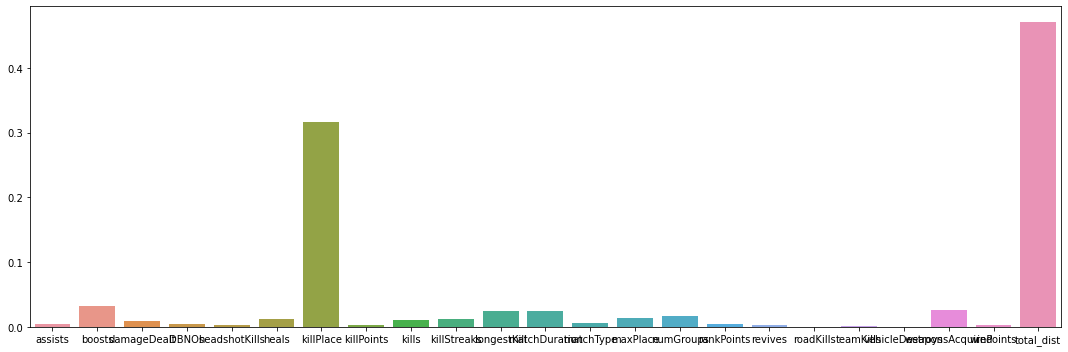

In [102]:
plt.figure(figsize=(15,5))
sns.barplot(col,etr_feat)
plt.tight_layout()

Since most of the variable is optimal,so there's no need to remove any columns.

# Predicting Using different algorithm.

In [0]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.10,random_state = 123)

In [0]:
linear_model = LinearRegression().fit(x_train,y_train)


In [0]:
tree_model = DecisionTreeRegressor().fit(x_train,y_train)


In [0]:
forest_model = RandomForestRegressor().fit(x_train,y_train)


In [0]:
ada_model = AdaBoostRegressor().fit(x_train,y_train)

In [110]:
xgb_model = XGBRegressor().fit(x_train,y_train)

[07:45:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
neighbor_model = KNeighborsRegressor().fit(x_train,y_train)

### Predicting on train

In [0]:
lineartrain = linear_model.predict(x_train)
treetrain = tree_model.predict(x_train)
foresttrain = forest_model.predict(x_train)
neighbortrain = neighbor_model.predict(x_train)
xgbtrain = xgb_model.predict(x_train)
adatrain = ada_model.predict(x_train)

In [136]:
k = len(x_train.columns)
n = len(x_train)
adr = (n-1)/(n-k-1)
print(k)
print(n)
print(adr)

23
270000
1.0000851927578747


Linear Model accuracy

In [137]:
print('MAE :',mean_absolute_error(y_train,lineartrain))
print('MSE :',mean_squared_error(y_train,lineartrain))
print('RMSE :',np.sqrt(mean_squared_error(y_train,lineartrain)))
print('R-Squared :',r2_score(y_train,lineartrain))
print('Adjusted R-Squared :',1-(adr*(1-r2_score(y_train,lineartrain))))
print('VIF :',1/(1-r2_score(y_train,lineartrain)))

MAE : 295.5499959527114
MSE : 156862.8735032593
RMSE : 396.05917929428085
R-Squared : 0.8156243580695212
Adjusted R-Squared : 0.8156086506001001
VIF : 5.423709930062576


Decision tree accuracy

In [138]:
print('MAE :',mean_absolute_error(y_train,treetrain))
print('MSE :',mean_squared_error(y_train,treetrain))
print('RMSE :',np.sqrt(mean_squared_error(y_train,treetrain)))
print('R-Squared :',r2_score(y_train,treetrain))
print('Adjusted R-Squared :',1-(adr*(1-r2_score(y_train,treetrain))))
print('VIF :',1/(1-r2_score(y_train,treetrain)))

MAE : 0.0
MSE : 0.0
RMSE : 0.0
R-Squared : 1.0
Adjusted R-Squared : 1.0
VIF : inf


RandomForest accuracy

In [139]:
print('MAE :',mean_absolute_error(y_train,foresttrain))
print('MSE :',mean_squared_error(y_train,foresttrain))
print('RMSE :',np.sqrt(mean_squared_error(y_train,foresttrain)))
print('R-Squared :',r2_score(y_train,foresttrain))
print('Adjusted R-Squared :',1-(adr*(1-r2_score(y_train,foresttrain))))
print('VIF :',1/(1-r2_score(y_train,foresttrain)))

MAE : 69.79871981481482
MSE : 9797.19164817889
RMSE : 98.98076403109287
R-Squared : 0.9884844421187313
Adjusted R-Squared : 0.9884834610765969
VIF : 86.8390407404065


KNN accuracy

In [140]:
print('MAE :',mean_absolute_error(y_train,neighbortrain))
print('MSE :',mean_squared_error(y_train,neighbortrain))
print('RMSE :',np.sqrt(mean_squared_error(y_train,neighbortrain)))
print('R-Squared :',r2_score(y_train,neighbortrain))
print('Adjusted R-Squared :',1-(adr*(1-r2_score(y_train,neighbortrain))))
print('VIF :',1/(1-r2_score(y_train,neighbortrain)))

MAE : 295.46431185185185
MSE : 155717.34779214815
RMSE : 394.61037466360176
R-Squared : 0.8169708018367239
Adjusted R-Squared : 0.8169552090745608
VIF : 5.463609140154365


XGBoost accuracy

In [141]:
print('MAE :',mean_absolute_error(y_train,xgbtrain))
print('MSE :',mean_squared_error(y_train,xgbtrain))
print('RMSE :',np.sqrt(mean_squared_error(y_train,xgbtrain)))
print('R-Squared :',r2_score(y_train,xgbtrain))
print('Adjusted R-Squared :',1-(adr*(1-r2_score(y_train,xgbtrain))))
print('VIF :',1/(1-r2_score(y_train,xgbtrain)))

MAE : 213.97242708206596
MSE : 89813.2933508352
RMSE : 299.68866069779017
R-Squared : 0.8944340158660514
Adjusted R-Squared : 0.8944250224087253
VIF : 9.472748330855694


ADABoost accuracy

In [142]:
print('MAE :',mean_absolute_error(y_train,adatrain))
print('MSE :',mean_squared_error(y_train,adatrain))
print('RMSE :',np.sqrt(mean_squared_error(y_train,adatrain)))
print('R-Squared :',r2_score(y_train,adatrain))
print('Adjusted R-Squared :',1-(adr*(1-r2_score(y_train,adatrain))))
print('VIF :',1/(1-r2_score(y_train,adatrain)))

MAE : 309.2866539062986
MSE : 166286.92218625202
RMSE : 407.7829351336959
R-Squared : 0.8045473900993101
Adjusted R-Squared : 0.8045307389524389
VIF : 5.116329735929867


### Predicting on test

In [0]:
linearpred = linear_model.predict(x_test)
treepred = tree_model.predict(x_test)
forestpred = forest_model.predict(x_test)
neighborpred = neighbor_model.predict(x_test)
xgbpred = xgb_model.predict(x_test)
adapred = ada_model.predict(x_test)

In [144]:
k1 = len(x_test.columns)
n1 = len(x_test)
adr1 = (n1-1)/(n1-k1-1)
print(k1)
print(n1)
print(adr1)

23
30000
1.0007672804910595


Linear accuracy

In [145]:
print('MAE :',mean_absolute_error(y_test,linearpred))
print('MSE :',mean_squared_error(y_test,linearpred))
print('RMSE :',np.sqrt(mean_squared_error(y_test,linearpred)))
print('R-Squared :',r2_score(y_test,linearpred))
print('Adjusted R-Squared :',1-(adr1*(1-r2_score(y_test,linearpred))))
print('VIF :',1/(1-r2_score(y_test,linearpred)))

MAE : 296.39633108061565
MSE : 157720.05020628785
RMSE : 397.1398370930419
R-Squared : 0.8139371032316823
Adjusted R-Squared : 0.813794340800882
VIF : 5.374526664739521


Decision tree accuracy

In [146]:
print('MAE :',mean_absolute_error(y_test,treepred))
print('MSE :',mean_squared_error(y_test,treepred))
print('RMSE :',np.sqrt(mean_squared_error(y_test,treepred)))
print('R-Squared :',r2_score(y_test,treepred))
print('Adjusted R-Squared :',1-(adr1*(1-r2_score(y_test,treepred))))
print('VIF :',1/(1-r2_score(y_test,treepred)))

MAE : 263.56606666666664
MSE : 142663.07486666666
RMSE : 377.7076579401941
R-Squared : 0.8316998698843355
Adjusted R-Squared : 0.8315707364778551
VIF : 5.941766053970064


RandomForest accuracy

In [147]:
print('MAE :',mean_absolute_error(y_test,forestpred))
print('MSE :',mean_squared_error(y_test,forestpred))
print('RMSE :',np.sqrt(mean_squared_error(y_test,forestpred)))
print('R-Squared :',r2_score(y_test,forestpred))
print('Adjusted R-Squared :',1-(adr1*(1-r2_score(y_test,forestpred))))
print('VIF :',1/(1-r2_score(y_test,forestpred)))

MAE : 188.62488133333332
MSE : 71291.09102068667
RMSE : 267.00391574036263
R-Squared : 0.9158976497171192
Adjusted R-Squared : 0.9158331196244949
VIF : 11.890274131893692


KNN accuracy

In [148]:
print('MAE :',mean_absolute_error(y_test,neighborpred))
print('MSE :',mean_squared_error(y_test,neighborpred))
print('RMSE :',np.sqrt(mean_squared_error(y_test,neighborpred)))
print('R-Squared :',r2_score(y_test,neighborpred))
print('Adjusted R-Squared :',1-(adr1*(1-r2_score(y_test,neighborpred))))
print('VIF :',1/(1-r2_score(y_test,neighborpred)))

MAE : 363.1679
MSE : 236810.26440933332
RMSE : 486.63154892519384
R-Squared : 0.7206340999584897
Adjusted R-Squared : 0.7204197479535206
VIF : 3.579534939129695


XGBoost accuracy

In [149]:
print('MAE :',mean_absolute_error(y_test,xgbpred))
print('MSE :',mean_squared_error(y_test,xgbpred))
print('RMSE :',np.sqrt(mean_squared_error(y_test,xgbpred)))
print('R-Squared :',r2_score(y_test,xgbpred))
print('Adjusted R-Squared :',1-(adr1*(1-r2_score(y_test,xgbpred))))
print('VIF :',1/(1-r2_score(y_test,xgbpred)))

MAE : 216.30213552441995
MSE : 92736.03273277651
RMSE : 304.5259147146208
R-Squared : 0.8905989767154282
Adjusted R-Squared : 0.89051503544456
VIF : 9.140682326149909


ADABoost accuracy

In [150]:
print('MAE :',mean_absolute_error(y_test,adapred))
print('MSE :',mean_squared_error(y_test,adapred))
print('RMSE :',np.sqrt(mean_squared_error(y_test,adapred)))
print('R-Squared :',r2_score(y_test,adapred))
print('Adjusted R-Squared :',1-(adr1*(1-r2_score(y_test,adapred))))
print('VIF :',1/(1-r2_score(y_test,adapred)))

MAE : 309.53431665025107
MSE : 167193.97487565043
RMSE : 408.8935984772205
R-Squared : 0.8027606810492085
Adjusted R-Squared : 0.8026093431677077
VIF : 5.069983030358598
